# Artificial Intelligence and Neural Networks based approach for signal denoising in non-linear spectroscopy applications

### Authors: Luca Polenta & Matteo Matera

In [ ]:
import numpy as np
import os, time, zipfile, math, sys
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix, eye, diags
from scipy.sparse.linalg import spsolve
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# keras imports for the dataset and the networks
import tensorflow as tf
import tensorflow.keras as keras
from keras import models, layers
from keras.regularizers import L1, L2, L1L2
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv1D, LeakyReLU, Input, Activation, Subtract, BatchNormalization, Lambda, Average
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Control Panel: Code Execution Settings

In [ ]:
# This variable changes the folder settings according to the needs of the notebook creators
nomeUtente = "LUCA" # "LUCA" or "MATTEO"
# IMPORTANT: If you are neither of the two creators, you can avoid the user setting,  but then you have to manually 
# change the root folders ("root_folder", "pathZip" and "root_drive") to suit your needs. They are in the cell after mounting google drive  

# Type of dataset
typeOfNoise = "HighNoise" # "HighNoise" or "LowNoise" or "MixedNoise" or "August17_MixedNoise"

# Activate or Deactivate the airPLS pre-processing
activate_airPLS = False

# Activate or Deactivate the normalization of the data between 0 and 1
requireNormalization = False

# Move the minimum value of each sample to 0 and the others accordingly
moveMinimumToZero = True

# Network settings. The first 3 are in parallel and the last one at the end. 
filterConv = [96,64,32,96] # Number of filters in the convolutions of the networks. The optimal values are: [96,64,32,96] 
depthNetwork = [17,12,7,3] # Network depth, i.e. the amount of layers Convolutions (with batch normalization layers if required). The optimal values are: [17,12,7,3]
ourKernelDim = [5,15,30,7] # Kernel size of each convolution of networks. The optimal values are: [5,15,30,7]
our_BatchNorm = [False, False, False, False] # Put or not the Batch Normalization each network


batch_size = 128        # Batch size of the model fit
number_of_epochs = 100  # Maximum number of epochs
train_test_split = 0.2  # We use 20% of the total data as test set
validation_split = 0.15 # We use 15% of the total train set as validation set
verbosity_mode = 1      # Verbose of the training
d_r = 5                 # dilation_rate of the convolution

lr = 0.0005 # Optimizer learning rate. The optimal value is: 0.0005
optimizer = keras.optimizers.Adam(learning_rate=lr)

l2_val = 0.000001          # L2 regularization factor. The optimal value is: 0.000001
ker_reg = L2(l2=l2_val)    # "None" or "L2(l2=l2_val)"

## Mounting Google Drive and importing the dataset

Mounting Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root_folder = '/content/drive/MyDrive/' # to save checkpoints

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading zip dataset and extracting it:

In [ ]:
# Setting the root folders for reading the dataset, saving the model and saving the loss and prediction printouts  
root_folder = '/content/drive/MyDrive/'
pathZip = "/content/dataset/FSRamanSpectra_simulationFumero"
root_drive = ""

if nomeUtente=="MATTEO":
  root_drive = "Colab Notebooks/EAI/EAI Project/"
elif nomeUtente=="LUCA":
  root_drive = "Uni/EAI1/"

if not os.path.exists(pathZip):
  if nomeUtente=="MATTEO":
      root_drive = "Colab Notebooks/EAI/EAI Project/"
      local_zip = root_folder+root_drive+'dataset/FSRamanSpectra_simulationFumero.zip'
  elif nomeUtente=="LUCA":
      root_drive = "Uni/EAI1/"
      local_zip = root_folder+root_drive+'dataset/FSRamanSpectra_simulationFumero.zip'
  zip_ref = zipfile.ZipFile(local_zip, 'r')
  zip_ref.extractall('/content/dataset/')
  zip_ref.close()
else:
  print("zip already opened")


# Creating folders to save printouts and results saves
cartellaRisultati = root_folder+root_drive+"results/"
cartellaSalvataggiMigliori = root_folder+root_drive+"savings/"
cartellaRisultatiTrain = cartellaRisultati+"TrainLOSS/"

if not os.path.exists(cartellaSalvataggiMigliori):
  # Create a new directory where to put the saving of the network because the folder did not exist
  os.makedirs(cartellaSalvataggiMigliori)
  print("Directory of model saves created!")

if not os.path.exists(cartellaRisultati):
  # Create a new directory where to put the predict printouts after network training because the folder did not exist
  os.makedirs(cartellaRisultati)
  print("Directory of model prediction created")

if not os.path.exists(cartellaRisultatiTrain):
  # Create a new directory where to put the prints of the loss had during the training of the net because the folder did not exist
  os.makedirs(cartellaRisultatiTrain)
  print("Directory of model loss created")

zip already opened


Create a filepath name which is characterized by the approaches adopted:

In [ ]:
# Create the name for the saving
nomeSalvataggio = "DnCNN_"

if typeOfNoise == "August17_MixedNoise":
    nomeSalvataggio += "Aug17MixedNoise_"
else:
    nomeSalvataggio += typeOfNoise+"_"

nomeSalvataggio += "epo"+str(number_of_epochs)+"_filtConvVARI_depthVARI_optADAM_lr"+str(lr)+"_"

if activate_airPLS:
    nomeSalvataggio += "airplsYES_"

if moveMinimumToZero:
    nomeSalvataggio += "scalatoYES_"    

if requireNormalization:
    nomeSalvataggio += "normYES_"

if our_BatchNorm[0]==True or our_BatchNorm[1]==True or our_BatchNorm[2]==True or our_BatchNorm[3]==True:
    nomeSalvataggio += "batchNormYES_"
    

nomeSalvataggio += "dilRate"+str(d_r)+"_"

nomeSalvataggio += "regL2"+str(l2_val)

print(nomeSalvataggio)

DnCNN_HighNoise_epo100_filtConvVARI_depthVARI_optADAM_lr0.0005_scalatoYES_dilRate5_regL21e-06


Importing the dataset in a form of numpy arrays:

In [ ]:
print(typeOfNoise)
base_dir = '/content/dataset/FSRamanSpectra_simulationFumero'
data_pure = np.loadtxt(base_dir+'/Sclean_'+typeOfNoise+'.txt')   #ex true
data_noisy = np.loadtxt(base_dir+'/Snoise_'+typeOfNoise+'.txt')  #ex mean
data_pure = data_pure.transpose()
data_noisy = data_noisy.transpose()

print(len(data_pure), "samples")
print(len(data_pure[0]), "timesteps for sample")
print("Shape:", data_pure.shape)

HighNoise
5000 samples
801 timesteps for sample
Shape: (5000, 801)


## Preprocessing

Definition of the airPLS algorithm. This algorithm was developed by Renato Lombardo and then translated and converted into various languages by Zhimin Zhang and Yizeng Liang. The repo from which it was obtained is at the following [link](https://github.com/zmzhang/airPLS)

In [ ]:
'''
airPLS.py Copyright 2014 Renato Lombardo - renato.lombardo@unipa.it
Baseline correction using adaptive iteratively reweighted penalized least squares

This program is a translation in python of the R source code of airPLS version 2.0
by Yizeng Liang and Zhang Zhimin - https://code.google.com/p/airpls
Reference:
Z.-M. Zhang, S. Chen, and Y.-Z. Liang, Baseline correction using adaptive iteratively reweighted penalized least squares. Analyst 135 (5), 1138-1146 (2010).

Description from the original documentation:

Baseline drift always blurs or even swamps signals and deteriorates analytical results, particularly in multivariate analysis.  It is necessary to correct baseline drift to perform further data analysis. Simple or modified polynomial fitting has been found to be effective in some extent. However, this method requires user intervention and prone to variability especially in low signal-to-noise ratio environments. The proposed adaptive iteratively reweighted Penalized Least Squares (airPLS) algorithm doesn't require any user intervention and prior information, such as detected peaks. It iteratively changes weights of sum squares errors (SSE) between the fitted baseline and original signals, and the weights of SSE are obtained adaptively using between previously fitted baseline and original signals. This baseline estimator is general, fast and flexible in fitting baseline.


LICENCE
This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Lesser General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Lesser General Public License for more details.

You should have received a copy of the GNU Lesser General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>
'''

def WhittakerSmooth(x,w,lambda_,differences=1):
    '''
    Penalized least squares algorithm for background fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        w: binary masks (value of the mask is zero if a point belongs to peaks and one otherwise)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background
        differences: integer indicating the order of the difference of penalties
    
    output
        the fitted background vector
    '''
    X=np.matrix(x)
    m=X.size
    i=np.arange(0,m)
    E=eye(m,format='csc')
    D=E[1:]-E[:-1] # numpy.diff() does not work with sparse matrix. This is a workaround.
    W=diags(w,0,shape=(m,m))
    A=csc_matrix(W+(lambda_*D.T*D))
    B=csc_matrix(W*X.T)
    background=spsolve(A,B)
    return np.array(background)

def airPLS(x, lambda_=100, porder=1, itermax=15):
    '''
    Adaptive iteratively reweighted penalized least squares for baseline fitting
    
    input
        x: input data (i.e. chromatogram of spectrum)
        lambda_: parameter that can be adjusted by user. The larger lambda is,  the smoother the resulting background, z
        porder: adaptive iteratively reweighted penalized least squares for baseline fitting
    
    output
        the fitted background vector
    '''
    m=x.shape[0]
    w=np.ones(m)
    for i in range(1,itermax+1):
        z=WhittakerSmooth(x,w,lambda_, porder)
        d=x-z
        dssn=np.abs(d[d<0].sum())
        if(dssn<0.001*(abs(x)).sum() or i==itermax):
            if(i==itermax): print('WARNING: max iteration reached!')
            break
        w[d>=0]=0 # d>0 means that this point is part of a peak, so its weight is set to 0 in order to ignore it
        w[d<0]=np.exp(i*np.abs(d[d<0])/dssn)
        w[0]=np.exp(i*(d[d<0]).max()/dssn) 
        w[-1]=w[0]
    return z

'''
if __name__=='__main__':
    #Example usage and testing
    print('Testing...')
    from scipy.stats import norm
    import matplotlib.pyplot as pl
    x=np.arange(0,1000,1)
    g1=norm(loc = 100, scale = 1.0) # generate three gaussian as a signal
    g2=norm(loc = 300, scale = 3.0)
    g3=norm(loc = 750, scale = 5.0)
    signal=g1.pdf(x)+g2.pdf(x)+g3.pdf(x)
    baseline1=5e-4*x+0.2 # linear baseline
    baseline2=0.2*np.sin(np.pi*x/x.max()) # sinusoidal baseline
    noise=np.random.random(x.shape[0])/500
    print('Generating simulated experiment')
    y1=signal+baseline1+noise
    y2=signal+baseline2+noise
    print('Removing baselines')
    c1=y1-airPLS(y1) # corrected values
    c2=y2-airPLS(y2) # with baseline removed
    print('Plotting results')
    fig,ax=pl.subplots(nrows=2,ncols=1)
    ax[0].plot(x,y1,'-k')
    ax[0].plot(x,c1,'-r')
    ax[0].set_title('Linear baseline')
    ax[1].plot(x,y2,'-k')
    ax[1].plot(x,c2,'-r')
    ax[1].set_title('Sinusoidal baseline')
    pl.show()
    print('Done!')
'''

print("airPLS algorithm created")


airPLS algorithm created


Processing of the dataset using the airPLS algorithm, if required:

In [ ]:
data_noisy_baselineCorrected = []
if activate_airPLS:
    for i in range(0, len(data_noisy)):
        data_noisy_baselineCorrected.append(data_noisy[i] - airPLS(data_noisy[i]))
        if(i%1000==0): print(i)
    print("airPLS completed")
else:
    print("the airPLS algorithm has not been applied to the dataset")

the airPLS algorithm has not been applied to the dataset


Plot few spectra:


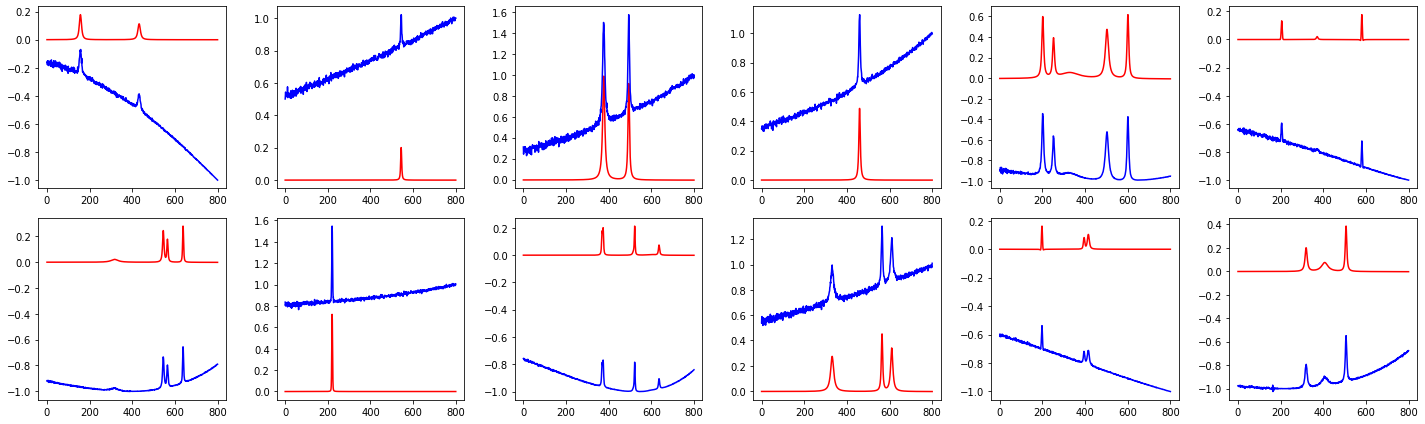

In [ ]:
plt.figure(figsize=(20,6))
for idx in range(12):
  plt.subplot(2,6,idx+1)
  plt.plot(data_pure[idx], '-r')
  plt.plot(data_noisy[idx], '-b')
  # Plotting of the dataset processed by airPLS only if it has been computed (so only if required)
  if activate_airPLS:
      plt.plot(data_noisy_baselineCorrected[idx], '-g')
plt.tight_layout()
plt.draw()

Processing of each sample of the dataset following the control panel settings. The dataset can be modified in the following ways:


*   Normalization of each signal between 0 and 1
*   Change the minimum of each signal so that the lowest value is zero and the other values are shifted accordingly

Then the dataset is put into a numpy array of two dimensions where the first elements are the samples and the second are the timesteps (sample,timesteps). Finally a third dimension of 1 is added which corresponds to the feature. In the end the shape is:

(sample,timesteps,feature) = (sample,timesteps,1)



In [ ]:
# Reshape data
data_noisy_r = []
data_pure_r = []

for i in range(len(data_noisy)):
    # Depending on the settings in the control panel, either the original noisy dataset or the noisy dataset modified by airPLS is read. 
    if activate_airPLS:
        noisy_sample = data_noisy_baselineCorrected[i]
    else:
        noisy_sample = data_noisy[i]
    # Reading the noise-free dataset we are aiming at
    pure_sample = data_pure[i]
    # reshape noisy signals between 0 and 1, if required
    if requireNormalization:
        noisy_sample = (noisy_sample - np.min(noisy_sample)) / (np.max(noisy_sample) - np.min(noisy_sample))
    # If required, change the minimum of each signal so that the lowest value is zero and the other values are shifted accordingly
    if moveMinimumToZero:
        # Computing the minimum in the sample
        min_noisy = np.amin(noisy_sample)
        # Subtracting the inverse of the minimum from the entire sample. 
        # If the minimum is positive, the curve will shift down, while if the minimum is negative, the curve will shift up.
        noisy_sample = np.sum(np.array([noisy_sample, [-min_noisy]], dtype=object))
    data_noisy_r.append(noisy_sample)
    data_pure_r.append(pure_sample)

data_noisy_r     = np.array(data_noisy_r)
data_pure_r      = np.array(data_pure_r)
# Changind the shape of the two sets
noisy_input_r    = data_noisy_r.reshape((data_noisy_r.shape[0], data_noisy_r.shape[1], 1))
pure_input_r     = data_pure_r.reshape((data_pure_r.shape[0], data_pure_r.shape[1], 1))

print("Noisy reshaped input shape:", noisy_input_r.shape)
print("Pure  reshaped input shape:", pure_input_r.shape)

Noisy reshaped input shape: (5000, 801, 1)
Pure  reshaped input shape: (5000, 801, 1)


Plotting a sample to show the pre-processing:

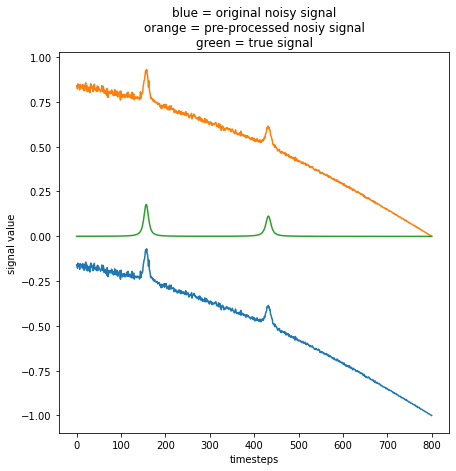

In [ ]:
plt.figure(figsize=(7,7))

plt.title('blue = original noisy signal\norange = pre-processed nosiy signal\ngreen = true signal')
plt.ylabel('signal value')
plt.xlabel('timesteps')
plt.plot(data_noisy[0])
plt.plot(noisy_input_r[0])
plt.plot(pure_input_r[0])
plt.show()

Computation of the dataset used for training and the dataset used for testing:

In [ ]:
# Train/test split
percentage_training = math.floor((1 - train_test_split) * len(noisy_input_r))
noisy_input, noisy_input_test = noisy_input_r[:percentage_training], noisy_input_r[percentage_training:]
pure_input, pure_input_test = pure_input_r[:percentage_training], pure_input_r[percentage_training:]

print(noisy_input.shape)
print(pure_input.shape)
print(noisy_input_test.shape)
print(pure_input_test.shape)

# Defining the number of timesteps as the length of one sample
n_timesteps = len(noisy_input[1]) # 801 in our cases
n_features = 1

(4000, 801, 1)
(4000, 801, 1)
(1000, 801, 1)
(1000, 801, 1)


## Model

Defining the DnCNN model:

In [ ]:
def DnCNN(inpt, num_timesteps, num_features, depth=10, filters=64, use_bnorm=True, kernel_dim=3):
    # First convolutional layer
    x = Conv1D(filters=filters, kernel_size=kernel_dim,
               strides=1, padding='same',
               kernel_initializer='Orthogonal',
               kernel_regularizer = ker_reg,
               bias_regularizer = ker_reg, 
               activity_regularizer = ker_reg)(inpt)
    x = Activation(LeakyReLU(alpha=0.05))(x)
    for i in range(depth-2):
        x = Conv1D(filters=filters, 
                   kernel_size=kernel_dim, strides=1, 
                   kernel_initializer='Orthogonal', 
                   padding='same', use_bias = False, 
                   kernel_regularizer = ker_reg,
                   bias_regularizer = ker_reg, 
                   activity_regularizer = ker_reg)(x)
        # Adding the batch normalization layers only if required
        if use_bnorm:
            x = BatchNormalization(axis=2, momentum=0.0, epsilon=0.0001)(x)
        x = Activation(LeakyReLU(alpha=0.05))(x)  
    # Last convolutional layer
    x = Conv1D(filters=num_features, 
               kernel_size=kernel_dim, strides=1, 
               kernel_initializer='Orthogonal', 
               padding='same', use_bias = False, 
               kernel_regularizer = ker_reg,
               bias_regularizer = ker_reg, 
               activity_regularizer = ker_reg)(x)
    return x

def parallelDnCNN(num_timesteps, num_features, depth=[10,10,10,10], filters=[64,64,64,64], use_bnorm=[True, True, True, True], kernel_dim=[5,15,30,7]):
    inpt = Input(shape=(num_timesteps, num_features))
    x1 = DnCNN(inpt, num_timesteps, num_features, depth[0], filters=filters[0], use_bnorm=use_bnorm[0], kernel_dim=kernel_dim[0])
    x2 = DnCNN(inpt, num_timesteps, num_features, depth[1], filters=filters[1], use_bnorm=use_bnorm[1], kernel_dim=kernel_dim[1])
    x3 = DnCNN(inpt, num_timesteps, num_features, depth[2], filters=filters[2], use_bnorm=use_bnorm[2], kernel_dim=kernel_dim[2])
    x = Average()([x1, x2, x3])
    x = DnCNN(x, num_timesteps, num_features, depth[3], filters=filters[3], use_bnorm=use_bnorm[3], kernel_dim=kernel_dim[3])
    x = Subtract()([inpt, x]) # input - noise
    model = Model(inputs=inpt, outputs=x)
    return model


In [ ]:
model = parallelDnCNN(n_timesteps, n_features, depthNetwork, filterConv, use_bnorm=our_BatchNorm, kernel_dim=ourKernelDim)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 801, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 801, 96)      576         ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 801, 96)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 801, 96)      46080       ['activation[0][0]']             
                                                                                              

Definition of the loss used during the training and compilation of the model. The loss used is the residual sum of squares (RSS). It is a measure of the discrepancy between the data and an estimating model, such as a linear regression. A small RSS indicates a close fit of the model to the data.

In [ ]:
def residual_sum_of_squares(y_true, y_pred):
    return K.sum(K.square(y_pred - y_true))

model.compile(optimizer=optimizer, loss=residual_sum_of_squares, metrics=[keras.losses.mean_squared_error, keras.losses.mean_absolute_error])


Defining callbacks:
checkpoint, earlystopping, reduction of the LR

*   Checkpoint: it is used to save the whole model only when it is the best. The analysis is made basing on the value of the loss of the validation dataset;
*   Reduction of the LR: it is computed using the ReduceLROnPlateau function that reduces the learning rate when a metric has stopped improving. In our case the metric is the loss of the validation dataset;
*   Earlystopping: it stops training when a monitored metric has stopped improving. In our case the metric is the loss of the validation dataset;
*   Tensorboard: it logs events during the training.



In [ ]:
model_filepath = cartellaSalvataggiMigliori+nomeSalvataggio+'.best.hdf5'

checkpoint = ModelCheckpoint(model_filepath,
                              monitor="val_loss", # quantity to be monitored: the loss of validation
                              verbose=1,
                              save_best_only=True, # if true, it only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten.
                              mode='min',  # If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity. For val_acc, this should be max, for val_loss this should be min, 
                              save_weights_only=False) # if True, then only the model's weights will be saved else the full model is saved 

reduce_lr = ReduceLROnPlateau(monitor="val_loss", # quantity to be monitored: the loss of validation
                              factor=0.5, # factor by which the learning rate will be reduced
                              mode='min', # In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing. On acc has to go max
                              patience=2, # number of epochs with no improvement after which learning rate will be reduced
                              min_lr=1e-10, # lower bound on the learning rate
                              verbose=1)

early_stop = EarlyStopping(monitor="val_loss", # quantity to be monitored: the loss of validation
                            min_delta=0.05, # Minimum change in the monitored quantity to qualify as an improvement
                            mode='min', # In min mode, training will stop when the quantity monitored has stopped decreasing. On acc has to go max
                            patience=7, # Number of epochs with no improvement after which training will be stopped
                            verbose=1)

tb_log_dir = './runs/DnCNN'

tboard = TensorBoard(log_dir=tb_log_dir, # the path of the directory where to save the log files to be parsed by TensorBoard
                     histogram_freq=0, # frequency (in epochs) at which to compute activation and weight histograms for the layers of the model
                     write_graph=False, # whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True.
                     write_grads=False,
                     write_images=False, # whether to write model weights to visualize as image in TensorBoard.
                     embeddings_freq=0, # frequency (in epochs) at which embedding layers will be visualized. If set to 0, embeddings won't be visualized.
                     embeddings_layer_names=None,
                     embeddings_metadata=None) # Dictionary which maps embedding layer names to the filename of a file in which to save metadata for the embedding layer

# defining our callback
ourCallback=[early_stop, reduce_lr, checkpoint, tboard]

## Training

Model training and plotting of loss variation in the validation dataset:

Tracking the change in validation dataset loss from the fifth epoch onward. It comes made from the fifth in then because there are of the cases in which the first losses are much elevated and the successive ones instead vary little, therefore in this way it is possible to see better in the detail the course of the loss during all the training.

Train on 3400 samples, validate on 600 samples
Epoch 1/100
3400/3400 [==============================] - ETA: 0s - loss: 2308.2455 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0725

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 310.77830, saving model to /content/drive/MyDrive/Uni/EAI1/savings/DnCNN_HighNoise_epo100_filtConvVARI_depthVARI_optADAM_lr0.0005_scalatoYES_dilRate5_regL21e-06.best.hdf5
3400/3400 [==============================] - 30s 9ms/sample - loss: 2308.2455 - mean_squared_error: 0.0225 - mean_absolute_error: 0.0725 - val_loss: 310.7783 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0355 - lr: 5.0000e-04
Epoch 2/100
3400/3400 [==============================] - ETA: 0s - loss: 133.9586 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0205
Epoch 2: val_loss improved from 310.77830 to 98.36539, saving model to /content/drive/MyDrive/Uni/EAI1/savings/DnCNN_HighNoise_epo100_filtConvVARI_depthVARI_optADAM_lr0.0005_scalatoYES_dilRate5_regL21e-06.best.hdf5
3400/3400 [==============================] - 24s 7ms/sample - loss: 133.9586 - mean_squared_error: 0.0013 - mean_absolute_error: 0.0205 - val_loss: 98.3654 - val_mean_squared_error: 0.0010 - 

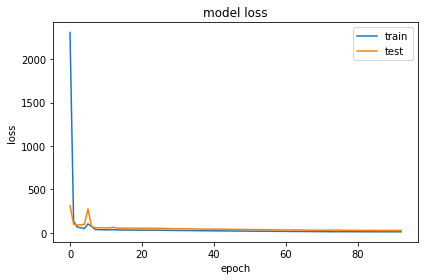

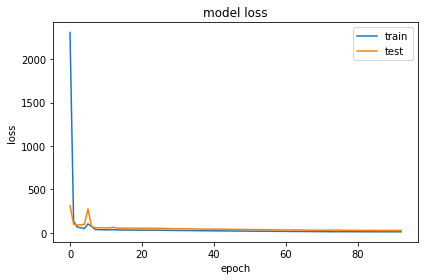

In [ ]:
history = model.fit(noisy_input, pure_input,
                    batch_size=batch_size, 
                    epochs=number_of_epochs,
                    verbose=1,
                    validation_split=validation_split,
                    callbacks=ourCallback)


# I print the trend of the train
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
#plt.savefig(cartellaRisultatiTrain+'TrainLOSS_'+nomeSalvataggio+'.png')

plt.tight_layout()

fig

## Prediction

Reading the saved optimal model:

In [ ]:
# load model 
get_custom_objects().update({'residual_sum_of_squares': residual_sum_of_squares})
model = load_model(model_filepath)

# predict the best model that we have saved
preds = model.predict(noisy_input_test)
preds.shape

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(1000, 801, 1)

Plotting of a samples in the 3 versions: with noise, without noise and predicted

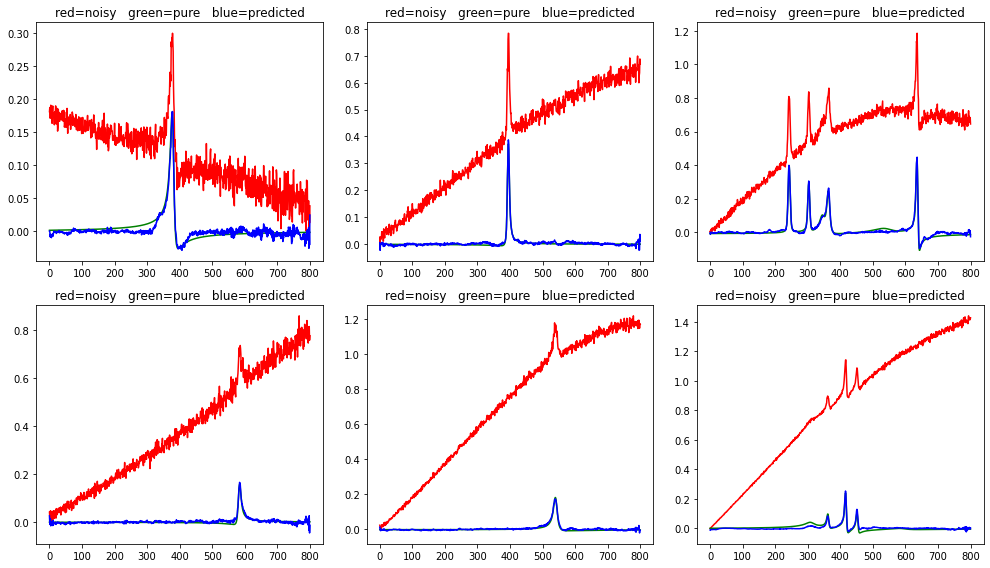

In [ ]:
printingIndexes=[0,1,10,11,13,20]

plt.figure(figsize=(14,8))
for id, i in enumerate(printingIndexes): 
  plt.subplot(2,3,id+1)
  plt.title('red=noisy   green=pure   blue=predicted')
  plt.plot(noisy_input_test[i], 'r')
  plt.plot(pure_input_test[i], 'g')
  plt.plot(preds[i], 'b')
plt.tight_layout()
plt.draw()

## Testing

First there is the definition of some testing and printing functions

In [ ]:
def get_peaks(signals, pure=False):
  all_peaks = []
  # For each signal
  for sig in signals:
      # Finding the max value
      max_val = max(sig)
      # Computing the minimum height to consider a peak 
      min_height = max_val / 6

      # Finding the peaks
      if pure == True:
        peaks_idxs, _ = find_peaks(sig)
      elif pure == False:
        # If the signal is predicted you have to use a different function to find the peaks with more accuracy
        peaks_idxs = find_peaks_cwt(sig, np.arange(1,35))
      
      # Creating arrays to have peaks and timesteps where they occur
      peaks = []
      peaks_values = []
      if pure == False:
          for idx in peaks_idxs:
            # Consider as a peak only values higher than min_height
            if sig[idx] > min_height:
              peaks.append(idx)
              peaks_values.append(sig[idx])
      elif pure == True:
          for idx in peaks_idxs:
            peaks.append(idx)
            peaks_values.append(sig[idx])
      # Storing the peaks in the array following the format [timestep, value]
      all_peaks.append([peaks, peaks_values])
  
  return all_peaks

# Definition of a printing function
def plot_peaks(signal, peaks, size=(10,4), whatPrinting=""):
    plt.figure(figsize=size)
    plt.plot(signal)
    if whatPrinting=="noisy":
      plt.title("Noisy Signal", size=16)
    elif whatPrinting=="pure":
      plt.title("Pure Signal", size=16)
    plt.scatter(peaks[0], peaks[1], s=100, c='red')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    '''
    if whatPrinting=="noisy":
      plt.savefig('/content/noisyPeaks.png',bbox_inches='tight')
    else if whatPrinting=="pure":
      plt.savefig('/content/purePeaks.png',bbox_inches='tight')
    '''
    plt.show()

# Computing the accuracy in predicting the number of peaks of each signal
def number_of_peaks_accuracy(pure_peaks, pred_peaks):
    assert len(pure_peaks) == len(pred_peaks)
    n_samples = len(pure_peaks)
    sum = 0.0
    for p1, p2 in zip(pure_peaks, pred_peaks):
      n_pure = len(p1[0])
      n_pred = len(p2[0])
      # If the number of peaks predicted is equal to the number of real peaks,
      # then the accuracy is 100%
      if n_pure == n_pred:
        sum += 100.0
      # Otherwise, we compute the difference (absolute value) between the no. of the
      # predicted ones and the no. of the real ones and then we compute the percentage
      # w.r.t the no. of the real peaks
      else:
        diff = abs(n_pure - n_pred)
        sum += 100.0 - (diff/n_pure*100)

    return sum / n_samples

# This function considers only the peaks that are correctly predicted by the model
# You can set the threshold of the timesteps (default = 4)
def clean_peaks(pure_peaks, pred_peaks, ts_threshold=4):  
    pred_peaks_ = []
    pure_peaks_ = []
    for (ts_pure, val_pure), (ts_pred, val_pred) in zip(pure_peaks, pred_peaks):
        ts_pure_ = []
        val_pure_ = []
        ts_pred_ = []
        val_pred_ = []
        for i in range(len(ts_pred)):
            for j in range(len(ts_pure)):
                # We consider as a correct peak in a threshold of ts_threshold (default = 4)
                if abs(ts_pure[j] - ts_pred[i]) <= ts_threshold:
                    ts_pure_.append(ts_pure[j])
                    val_pure_.append(val_pure[j])
                    ts_pred_.append(ts_pred[i])
                    val_pred_.append(val_pred[i])
        pred_peaks_.append([ts_pred_, val_pred_])
        pure_peaks_.append([ts_pure_, val_pure_])

    return pred_peaks_, pure_peaks_

# This function computes the prediction of the accuracy along the y-axis
def precision_along_y(pure_peaks, pred_peaks,
                      threshold_low_peaks=20,     # percentage of admissible error for the low peaks
                      threshold_high_peaks=10,    # percentage of admissible error for the high peaks
                      max_low_peaks=0.1):         # value above which we consider the peak as high one
    correct = 0
    n_peaks = 0
    for p1, p2 in zip(pure_peaks, pred_peaks):
        pure = p1[1]
        pred = p2[1]
        # make sure that the number of pure peaks is equal to the number of predicted peaks
        assert len(pure) == len(pred)
        for y, yhat in zip(pure, pred):
            err = abs(y - yhat) / y * 100
            if (y <= max_low_peaks and err <= threshold_low_peaks) or (y > max_low_peaks and err <= threshold_high_peaks):
                correct += 1
            n_peaks += 1
  
    return correct / n_peaks * 100

# This function returns:
# --> cor: number of correctly predicted peaks
# --> inv: number of incorrectly predicted peaks
# --> npr: number of not predicted peaks
def invented_notpredicted_accuracy(pure_peaks, pred_peaks, ts_threshold=4):
    cor = 0
    inv = 0
    npr = 0
    for (ts_pure, _), (ts_pred, _) in zip(pure_peaks, pred_peaks):
        correct = 0
        for i in range(len(ts_pure)):
            for j in range(len(ts_pred)):
                if abs(ts_pure[i] - ts_pred[j]) <= ts_threshold:
                  correct += 1
        # no. of not predicted peaks is the difference between the no. of real peaks
        # and the number of correctly predicted peaks
        not_predicted = len(ts_pure) - correct
        # no. of not incorrectly predicted peaks is the difference between the
        # no. of predicted peaks and the number of correctly predicted peaks
        invented = len(ts_pred) - correct

        cor += correct
        inv += invented
        npr += not_predicted

    return cor, inv, npr

# Computing the number of correctly predicted peaks
def number_of_correct_peaks(pure_peaks):
    n = 0
    for p in pure_peaks:
      n += len(p[0])
    
    return n

# A function that computes the RMSE and MAPE for each sample and then averages them all
def RMSE_and_MAPE(pures, preds):
    rmse = 0.0
    mape = 0.0
    tot = 0
    pures = pures.reshape((pures.shape[0], pures.shape[1]))
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    for pure, pred in zip(pures, preds):
      rmse += mean_squared_error(pure, pred, squared=False) # If "squared" is false, then RMSE activates instead of MSE
      mape += mean_absolute_percentage_error(pure, pred)
      tot += 1
    
    return rmse/tot, mape/tot

Identification of peaks and the timesteps at which they occur:

In [ ]:
pred_peaks = get_peaks(preds.reshape((preds.shape[0], preds.shape[1])))
pure_peaks = get_peaks(pure_input_test.reshape((pure_input_test.shape[0], pure_input_test.shape[1])), pure=True)

Plotting a predicted signal and a clean signal with their respective peaks identified:

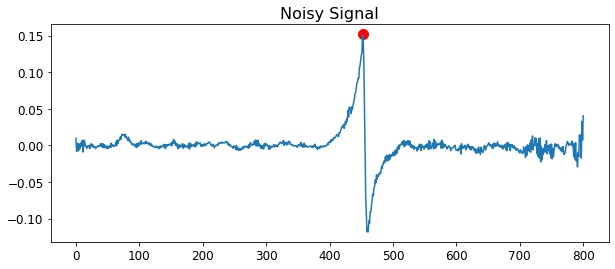

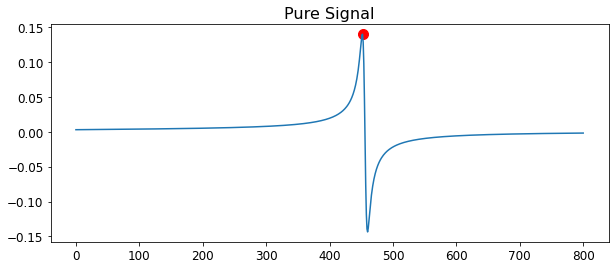

In [ ]:
i = 4
plot_peaks(preds[i], pred_peaks[i],whatPrinting="noisy")
plot_peaks(pure_input_test[i], pure_peaks[i],whatPrinting="pure")

Printing accuracy in predicting the number of peaks of each signal:

In [ ]:
acc = number_of_peaks_accuracy(pure_peaks, pred_peaks)
print("Accuracy: {0:.2f} %".format(acc))

Accuracy: 83.56 %


Computing only the correct peaks (threshold +-4):

In [ ]:
pred_peaks_, pure_peaks_ = clean_peaks(pure_peaks, pred_peaks)

Computing and printing the prediction of the accuracy along the y-axis with the threhsold 10-20:

In [ ]:
threshold_low_peaks=20
threshold_high_peaks=10
max_low_peaks=0.15

prec_along_y = precision_along_y(pure_peaks_, pred_peaks_,
                  threshold_low_peaks=threshold_low_peaks,
                  threshold_high_peaks=threshold_high_peaks,
                  max_low_peaks=max_low_peaks)

print("Precision along y axis: {0:.2f} %".format(prec_along_y))
print("")
print("Maximum allowed percentage error for high peaks (>{0:.2f}) : {1:.2f} %".format(max_low_peaks, threshold_high_peaks))
print("Maximum allowed percentage error for low peaks (<={0:.2f}) : {1:.2f} %".format(max_low_peaks, threshold_low_peaks))

Precision along y axis: 78.72 %

Maximum allowed percentage error for high peaks (>0.15) : 10.00 %
Maximum allowed percentage error for low peaks (<=0.15) : 20.00 %


Computing and printing the prediction of the accuracy along the y-axis with the threhsold 15-30:

In [ ]:
threshold_low_peaks=30
threshold_high_peaks=15
max_low_peaks=0.15

prec_along_y = precision_along_y(pure_peaks_, pred_peaks_,
                  threshold_low_peaks=threshold_low_peaks,
                  threshold_high_peaks=threshold_high_peaks,
                  max_low_peaks=max_low_peaks)

print("Precision along y axis: {0:.2f} %".format(prec_along_y))
print("")
print("Maximum allowed percentage error for high peaks (>{0:.2f}) : {1:.2f} %".format(max_low_peaks, threshold_high_peaks))
print("Maximum allowed percentage error for low peaks (<={0:.2f}) : {1:.2f} %".format(max_low_peaks, threshold_low_peaks))

Precision along y axis: 90.67 %

Maximum allowed percentage error for high peaks (>0.15) : 15.00 %
Maximum allowed percentage error for low peaks (<=0.15) : 30.00 %


Computing and printing various accuracy on the performance of the model:

In [ ]:
correct, invented, not_predicted = invented_notpredicted_accuracy(pure_peaks, pred_peaks)
n_correct_peaks = number_of_correct_peaks(pure_peaks)
rmse, mape = RMSE_and_MAPE(pure_input_test, preds)

print("Total number of correct peaks:", n_correct_peaks)
print("Peaks correctly predicted:", correct)
print("Peaks uncorrectly predicted:", invented)
print("Peaks not predicted:", not_predicted)
print("RMSE: {0:.7f}".format(rmse))
print("MAPE: {0:.7f}".format(mape))

Total number of correct peaks: 3222
Peaks correctly predicted: 2627
Peaks uncorrectly predicted: 125
Peaks not predicted: 595
RMSE: 0.0130064
MAPE: 17.8273116
